# An Experiment without Encoders
---------

<font size=4px>This notebook was implemented to see how a model without the encoders would perform on the dataset. The model architecture is as follows:

<font size=3px>
1. Conv(1, 32) -> ReLU -> Dropout -> Maxpool</br>
2. Conv(32, 64) -> ReLU -> Dropout -> Maxpool</br>
3. Conv(64, 128) -> ReLU -> Dropout -> Maxpool</br>
4. AveragePooling</br>
5. Fully Connected Layer (128, 62)</br>
</font>

<font color='blue'>Optimizer</font>: Adam (lr: 0.001)</br>
<font color='blue'>Loss</font>: CrossEntropyLoss</br>


**Conclusions**</br>
At epoch 100:</br>
Training Accuracy: 88.65</br>
Validation Accuracy: 75.64</br>

<font color='grey'>*The following code is implemented in PyTorch.*</font>


#Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Point 1's data is accessed via the zip file stored in the drive
# This zip file is transferred to the disk of the google colab, 
# because accessing it from the disk directly is faster than
# accessing the images from the drive

# Link to the zip file: https://drive.google.com/file/d/1g4dHphWLCX1PisdXacrfw8kdn7MGoxv5/view?usp=sharing
!cp -r "/content/drive/MyDrive/MIDAS/Point1/train.zip" "/content/train.zip" 
!unzip train.zip

In [ ]:
import numpy as np
import torch
import csv
from torch import nn
import pandas as pd
import cv2 as cv
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, ZeroPad2d
from torchvision import transforms
import shutil
from sklearn.metrics import auc, confusion_matrix, classification_report
import seaborn as sns
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import random

#Data Preparation

In [ ]:
#All images are resized to 200 * 200 and have been normalized
def _preprocess(image):
    # Preprocessing step
    img_transform = transforms.Compose([
        transforms.ToPILImage(),               #Conversion to PIL Image
        transforms.Resize((200, 200)),         #Resize image to 200 * 200
        transforms.ToTensor(),                 #Conversion to Tensor
        transforms.Normalize((0.5, ), (0.5,))  #Normalise Image
    ])
    return img_transform(image)

In [ ]:
#Class used by DataLoader for training data
class Images_train(Dataset):
  def __init__(self, df):
        #DataFrame Structure must be of the form: | FilePath | Label |
        self.data = df

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    #print(index)
    image1 = cv.imread(self.data.iloc[index, 0], cv.IMREAD_GRAYSCALE) #Column 0: FilePath
    image1 = _preprocess(image1)

    label = self.data.iloc[index, 1] #Column 1: Label

    return image1, torch.from_numpy(np.array([label], dtype=np.float32))

In [ ]:
#Class used by DataLoader for testing data
class Images_test(Dataset):
  def __init__(self, df):
        #DataFrame Structure must be of the form: | FilePath | Label |
        self.data = df

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    #print(index)
    image1 = cv.imread(self.data.iloc[index, 0], cv.IMREAD_GRAYSCALE) #Column 0: FilePath
    image1 = _preprocess(image1)

    label = self.data.iloc[index, 1] #Column 1: Label

    return image1, torch.from_numpy(np.array([label], dtype=np.float32))

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MIDAS/pointOne_cpath.csv")
df = df.sample(frac = 1)
df.head()

,FilePath,Label
1888,/content/train/Sample053/img053-011.png,52
1838,/content/train/Sample054/img054-049.png,53
1504,/content/train/Sample055/img055-004.png,54
1030,/content/train/Sample016/img016-046.png,15
63,/content/train/Sample051/img051-010.png,50


In [ ]:
df.shape

(2480, 2)

In [ ]:
#No augmentation has been applied
df_train, df_valid = train_test_split(df, test_size=0.25) #Split of 75/25
train_dataset = Images_train(df_train)
valid_dataset = Images_test(df_valid)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True) #Train
val_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True) #Test

train_iter = iter(train_loader)
images1, labels = train_iter.next()
print('images shape on batch size = {}'.format(images1.size()))
print('labels shape on batch size = {}'.format(labels.size()))

val_iter = iter(val_loader)
images1, labels = val_iter.next()
print('images shape on batch size = {}'.format(images1.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 1, 200, 200])
labels shape on batch size = torch.Size([8, 1])
images shape on batch size = torch.Size([1, 1, 200, 200])
labels shape on batch size = torch.Size([1, 1])


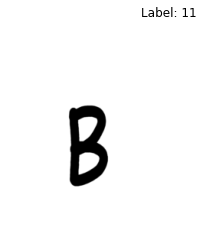

In [ ]:
plt.figure()
plt.subplot(121)
plt.imshow(images1[0][0], cmap="gray")
plt.axis("Off")
plt.suptitle("Label: {}".format(int(labels[0][0])))
plt.show()

#Model Creation

Architecture:
<font size=3px>
1. Conv(1, 32) -> ReLU -> Dropout -> Maxpool</br>
2. Conv(32, 64) -> ReLU -> Dropout -> Maxpool</br>
3. Conv(64, 128) -> ReLU -> Dropout -> Maxpool</br>
4. AveragePooling</br>
5. Fully Connected Layer (128, 62)</br>
</font>

-----

In [ ]:
class smallModel(nn.Module):
  def __init__(self):
    super(smallModel, self).__init__()
    
    self.zp1 = nn.ZeroPad2d(1)
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.mp1 = nn.MaxPool2d(kernel_size=2)
    self.dp = nn.Dropout(p=0.3)

    self.zp2 = nn.ZeroPad2d(1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.mp2 = nn.MaxPool2d(kernel_size=2)

    self.zp3 = nn.ZeroPad2d(1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.mp3 = nn.MaxPool2d(kernel_size=2)

    self.relu = nn.ReLU()

    self.fc = nn.Linear(128, 62)

    self.avgpool = nn.AdaptiveAvgPool2d(1) #Averages each filter and returns a single value


  def forward(self, x):
    x = self.dp(self.relu(self.conv1(x))) #Conv -> ReLU -> Dropout: 200 * 200 * 32
    x = self.mp1(x)                       #MaxPool

    x = self.dp(self.relu(self.conv2(x))) #Conv -> ReLU -> Dropout: 100 * 100 * 64
    x = self.mp2(x)                       #MaxPool

    x = self.dp(self.relu(self.conv3(x))) #Conv -> ReLU -> Dropout: 50 * 50 * 128
    x = self.mp3(x)                       #MaxPool

    x = self.avgpool(x).view(-1, 128)     #AveragePooling: 1 * 128 

    x = self.fc(x)                        #Fully Connected Layer: 1 * 62
  
    return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smallModel().to(device)
print(model)

smallModel(
  (zp1): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dp): Dropout(p=0.3, inplace=False)
  (zp2): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (zp3): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

#Model Training

In [ ]:
#Returns number of elements that are equal in the out (output) and labels (target) sensor
def accuracy(out, labels):
    count = 0
    _,pred = torch.max(out, dim=1)

    for i in range(output.shape[0]): #Element by element equality check
      if pred[i] == labels[i][0]:
        count = count + 1
    return count

In [ ]:
chkpt_path = "/content/drive/MyDrive/MIDAS/Point1/model.pt"
best_path = "/content/drive/MyDrive/MIDAS/Point1/best_model.pt"

train_loss_list = []
valid_loss_list = []
train_accuracy = []
valid_accuracy = []

#Initialisation
epochs = 10
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
min_valid_loss = np.Inf
check_epoch = 5
epoch_no_improve = 0
i = 0


for epoch in range(1, 101):
  train_loss = 0
  valid_loss = 0
  tcorrect = 0
  vcorrect = 0
  model.train()

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  #Training Loop
  print("Training: ")
  for batch, (img, target) in enumerate(train_loader):
    #print(batch)
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    optimizer.zero_grad()
    output = model(img) #Input passed to the model (Forward Pass)

    loss = criterion(output, target.view(-1)) #Loss Calculation

    loss.backward() #Backword Propogation
    optimizer.step()

    train_loss += loss.item()
    tcorrect += accuracy(output, target) #Keeps track of number of correct predictions in all batches
  
  #Evaluation Loop 
  model.eval()
  print("Validation: ")
  for batch, (img, target) in enumerate(val_loader):
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    output = model(img) #Input passed to the model (Forward Pass)
    
    loss = criterion(output, target.view(-1)) #Loss Calculation,  xxx Backward prop not performed

    valid_loss += loss.item()
    vcorrect += accuracy(output, target) #Keeps track of number of correct predictions in all batches
    
  #Calculate average losses
  train_loss = train_loss/len(train_loader) #Average Training loss in one epoch
  valid_loss = valid_loss/len(val_loader).  #Average Validation loss in one epoch
  train_loss_list.append(train_loss)
  valid_loss_list.append(valid_loss)

  tcorrect = tcorrect/len(train_dataset)    #Average Training accuracy in one epoch : (Sum of correctly predicted samples in one epoch) / (Divided by total length of samples)
  vcorrect = vcorrect/len(valid_dataset)    #Average Validation accuracy in one epoch : (Sum of correctly predicted samples in one epoch) / (Divided by total length of samples)
  train_accuracy.append(tcorrect)
  valid_accuracy.append(vcorrect)
  
  #Print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
      epoch, train_loss, tcorrect, valid_loss, vcorrect))

  #if epoch % 5 == 0 :
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, chkpt_path)
    
  #Saves the best model
  if valid_loss < min_valid_loss :
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'loss': loss,}, chkpt_path)
    shutil.copyfile(chkpt_path, best_path)
    min_valid_loss = valid_loss
    epoch_no_improve = 0
  else:
    epoch_no_improve = epoch_no_improve + 1

Training: 
Validation: 
Epoch: 1 	Training Loss: 4.133459 	Training Accuracy: 0.016129 	Validation Loss: 4.132100 	Validation Accuracy: 0.008065
Training: 
Validation: 
Epoch: 2 	Training Loss: 4.098113 	Training Accuracy: 0.020430 	Validation Loss: 4.099402 	Validation Accuracy: 0.012903
Training: 
Validation: 
Epoch: 3 	Training Loss: 3.907856 	Training Accuracy: 0.041398 	Validation Loss: 3.895897 	Validation Accuracy: 0.041935
Training: 
Validation: 
Epoch: 4 	Training Loss: 3.566398 	Training Accuracy: 0.083333 	Validation Loss: 3.641416 	Validation Accuracy: 0.106452
Training: 
Validation: 
Epoch: 5 	Training Loss: 3.264085 	Training Accuracy: 0.139785 	Validation Loss: 3.429914 	Validation Accuracy: 0.151613
Training: 
Validation: 
Epoch: 6 	Training Loss: 2.969350 	Training Accuracy: 0.190323 	Validation Loss: 3.193156 	Validation Accuracy: 0.217742
Training: 
Validation: 
Epoch: 7 	Training Loss: 2.655211 	Training Accuracy: 0.261290 	Validation Loss: 2.929591 	Validation Accu

#Visualisation and Evaluation

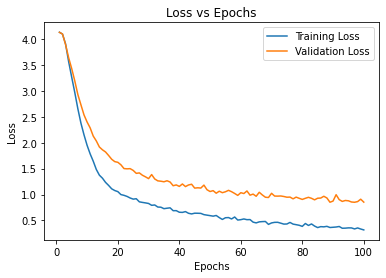

In [ ]:
a = [i for  i in range(1, 101)]
plt.plot(a, train_loss_list, label = 'Training Loss')
plt.plot(a, valid_loss_list, label = 'Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()

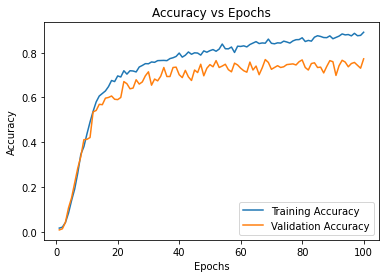

In [ ]:
a = [i for  i in range(1, 101)]
plt.plot(a, train_accuracy, label = 'Training Accuracy')
plt.plot(a, valid_accuracy, label = 'Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()

In [ ]:
print("Training Accuracy: ", 88.65)
print("Validation Accuracy: ", 75.64)

Training Accuracy:  88.65
Validation Accuracy:  75.64
